In [1]:
import os
import io
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import seaborn as sns


In [2]:
data_path = "C:/Users/andy7/PycharmProjects/GANForImages/Portraits"

dataset = keras.utils.image_dataset_from_directory(
    data_path, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 4117 files.


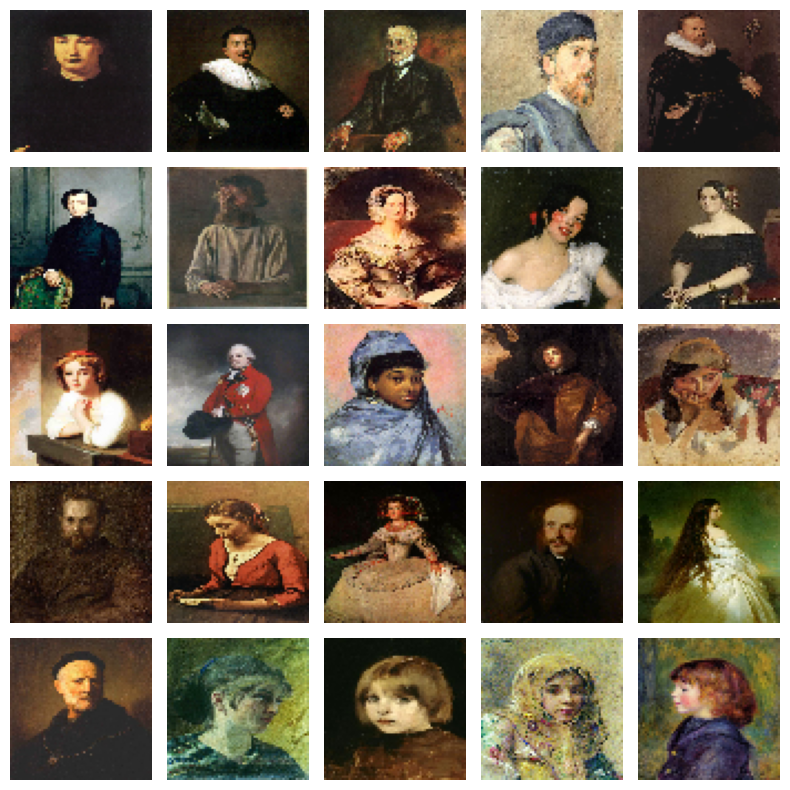

In [3]:
import matplotlib.pyplot as plt
import numpy as np

images = next(iter(dataset.take(25)))

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")
    plt.gca().set_aspect('auto')

plt.tight_layout()
plt.show()

In [4]:
latent_dim = 128
generator = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(8 * 8 * 128),
    layers.Reshape((8, 8, 128)),
    
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.2),
    
    layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh")
], name="generator")

C:\Users\andy7\PycharmProjects\pythonProject1\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [5]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,983,235 (15.19 MB)

 Trainable params: 3,981,443 (15.19 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [6]:
# Create the discriminator
discriminator = models.Sequential([
    layers.Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation="tanh")
], name="discriminator")

In [7]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,265 (2.58 MB)

 Trainable params: 675,265 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [9]:
# Define a custom callback to generate and save images after each epoch
class ImageGeneratorCallback(keras.callbacks.Callback):
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        self.generated_images = []

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        self.generated_images.append(generated_images)
        if (epoch + 1) % 20 == 0 or (epoch + 1) == epochs:
            fig, axs = plt.subplots(6, 6, figsize=(5, 5))
            for i in range(6):
                for j in range(6):
                    axs[i, j].imshow(generated_images[i * 6 + j])
                    axs[i, j].axis('off')
            # Add a subtitle displaying the epoch number
            plt.suptitle(f"Epoch {epoch + 1}/{epochs} - D Loss: {logs['d_loss']:.4f}, G Loss: {logs['g_loss']:.4f}")
            plt.show()

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - d_loss: 1.8070 - g_loss: 0.2048
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - d_loss: 0.6090 - g_loss: 1.2304
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 422s 3s/step - d_loss: 0.7295 - g_loss: 1.0287
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - d_loss: 0.7074 - g_loss: 0.8917
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - d_loss: 0.6801 - g_loss: 0.8700
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - d_loss: 0.6596 - g_loss: 0.8852
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - d_loss: 0.6607 - g_loss: 0.8969
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - d_loss: 0.6969 - g_loss: 0.8824
Epoch 9/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - d_loss: 0.6692 - g_loss: 0.8825
Epoch 10/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - d_loss: 0.6815 - g_loss: 0.8896
Epoch 11/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - d_loss: 0.6915 - g_loss: 0.8454
Epoch 12/100
129/129 ━━━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

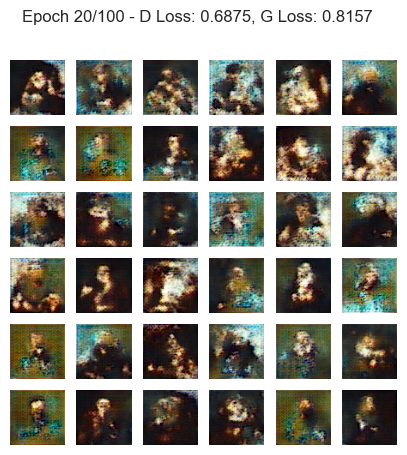

129/129 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - d_loss: 0.6883 - g_loss: 0.8224
Epoch 21/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - d_loss: 0.6804 - g_loss: 0.8155
Epoch 22/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - d_loss: 0.6774 - g_loss: 0.8060
Epoch 23/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - d_loss: 0.6743 - g_loss: 0.8078
Epoch 24/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - d_loss: 0.6724 - g_loss: 0.8220
Epoch 25/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - d_loss: 0.6738 - g_loss: 0.8247
Epoch 26/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - d_loss: 0.6716 - g_loss: 0.8223
Epoch 27/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - d_loss: 0.6705 - g_loss: 0.8203
Epoch 28/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - d_loss: 0.6736 - g_loss: 0.8318
Epoch 29/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - d_loss: 0.6672 - g_loss: 0.8194
Epoch 30/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - d_loss: 0.6683 - g_loss: 0.8269
Epoch 31/100
129/129 ━━━━━━━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

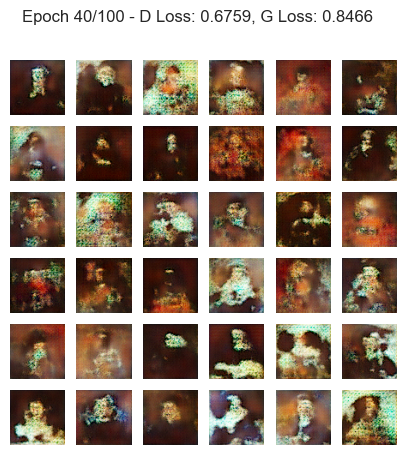

129/129 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - d_loss: 0.6990 - g_loss: 0.9159
Epoch 41/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - d_loss: 0.6661 - g_loss: 0.8391
Epoch 42/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - d_loss: 0.6627 - g_loss: 0.8335
Epoch 43/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - d_loss: 0.6594 - g_loss: 0.8292
Epoch 44/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - d_loss: 0.6629 - g_loss: 0.8364
Epoch 45/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - d_loss: 0.6604 - g_loss: 0.8299
Epoch 46/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - d_loss: 0.6610 - g_loss: 0.8421
Epoch 47/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - d_loss: 0.6578 - g_loss: 0.8275
Epoch 48/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - d_loss: 0.6591 - g_loss: 0.8276
Epoch 49/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - d_loss: 0.6625 - g_loss: 0.8168
Epoch 50/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - d_loss: 0.6566 - g_loss: 0.8284
Epoch 51/100
129/129 ━━━━━━━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

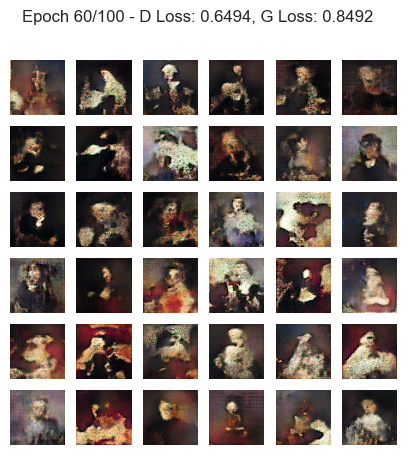

129/129 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - d_loss: 0.6509 - g_loss: 0.8548
Epoch 61/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - d_loss: 0.6483 - g_loss: 0.8482
Epoch 62/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - d_loss: 0.6514 - g_loss: 0.8433
Epoch 63/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - d_loss: 0.6448 - g_loss: 0.8440
Epoch 64/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 420s 3s/step - d_loss: 0.6449 - g_loss: 0.8468
Epoch 65/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - d_loss: 0.6459 - g_loss: 0.8485
Epoch 66/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - d_loss: 0.6421 - g_loss: 0.8509
Epoch 67/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - d_loss: 0.6474 - g_loss: 0.8623
Epoch 68/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - d_loss: 0.6448 - g_loss: 0.8519
Epoch 69/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - d_loss: 0.6459 - g_loss: 0.8549
Epoch 70/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - d_loss: 0.6458 - g_loss: 0.8518
Epoch 71/100
129/129 ━━━━━━━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

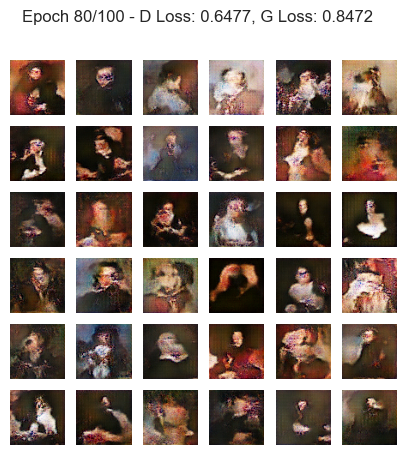

129/129 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - d_loss: 0.6477 - g_loss: 0.8444
Epoch 81/100
 75/129 ━━━━━━━━━━━━━━━━━━━━ 3:00 3s/step - d_loss: 0.6496 - g_loss: 0.8464

KeyboardInterrupt: 

In [10]:
epochs = 100
batch_size = 32
initial_learning_rate = 0.0001
decay_steps = 1000
decay_rate = 0.95
epsilon = 1e-07

d_learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True
)
g_learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True
)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=d_learning_rate_schedule, epsilon=epsilon),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=g_learning_rate_schedule, epsilon=epsilon),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

image_callback = ImageGeneratorCallback(latent_dim)
history = gan.fit(dataset, epochs=epochs, batch_size=batch_size, callbacks=[image_callback])

In [11]:
fig = plt.figure(figsize=(15, 4))
ax = sns.lineplot(data=history.history)
ax.set(xlabel="Epochs")
ax.set(ylabel="Loss")
ax.set_title("Learning Curve")
plt.show()

NameError: name 'history' is not defined

<Figure size 1500x400 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

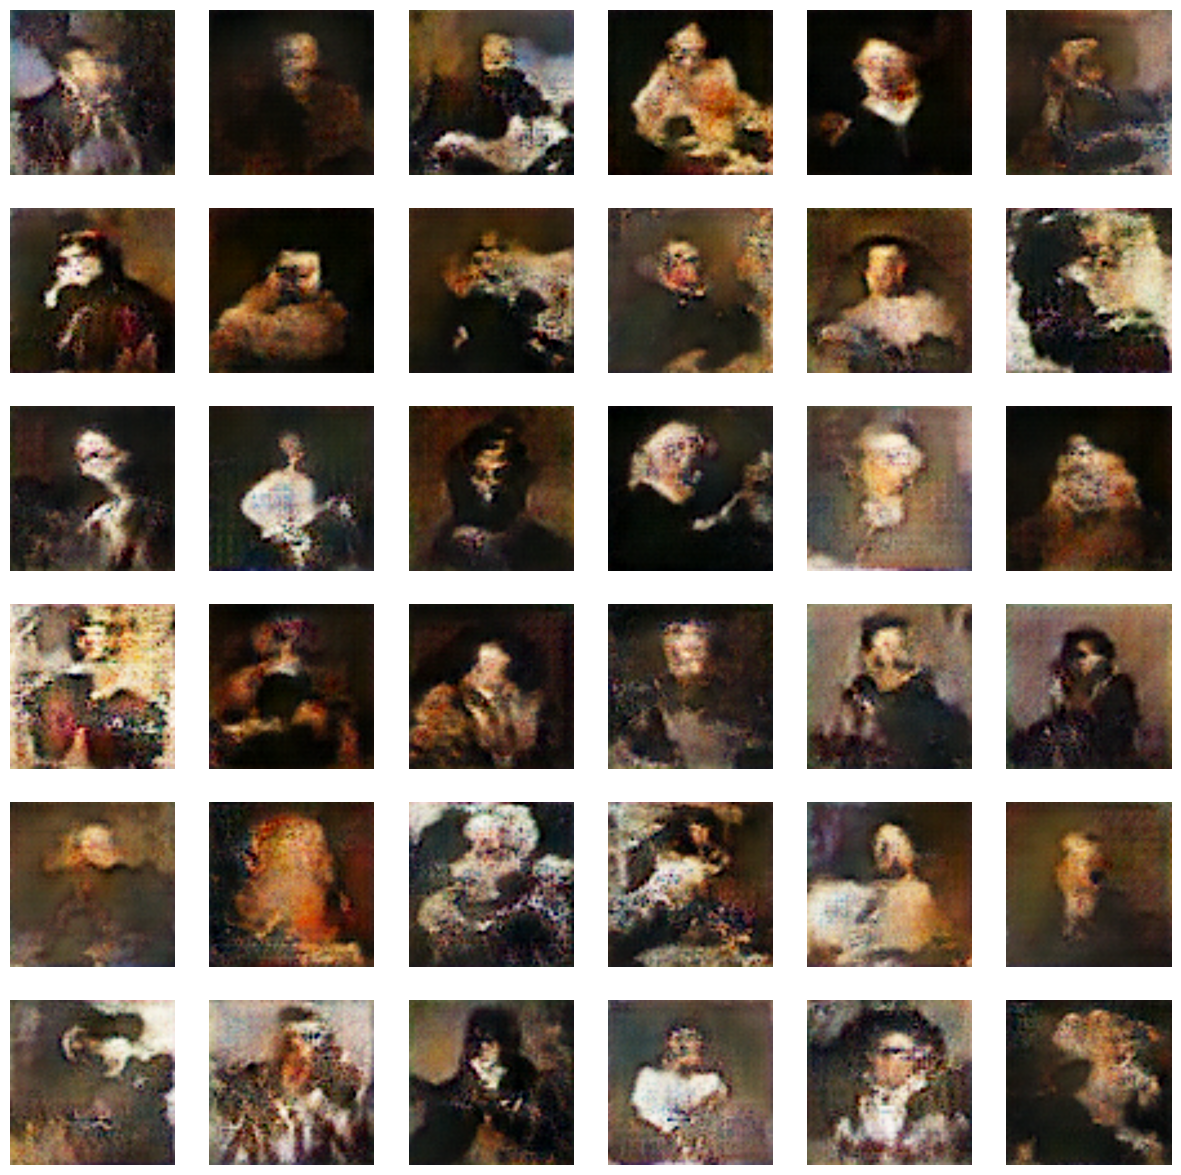

In [13]:
num_images=36

# Сгенерированные изображения с помощью обученного генератора
generated_images = generator(tf.random.normal([num_images, latent_dim]), training=False)

plt.figure(figsize=(15, 15))  # Увеличим размер фигуры для более крупных изображений
for i in range(num_images):
    plt.subplot(num_images//6, num_images//6, i+1)
    plt.imshow(tf.image.resize(generated_images[i], (500, 500)), cmap='gray', vmin=0, vmax=1)  # Изменим размер изображения на 500x500
    plt.axis('off')
plt.show()